In [39]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import scipy.optimize as op

# Downloading all data from the ACCESS files and merging into a single dataset

In [40]:
shortnames = ['sea_level_SO_monthly', 'surface_pot_temp', 'surface_salt', 'temp_yflux_adv_30S', 'temp_yflux_adv_60S', 'u_zonalSlices', 'v_zonalSlices', 'pbot_t']

access_data = xr.merge([xr.open_dataset(f"data/{shortname}.nc") for shortname in shortnames], compat='override')

access_data

<xarray.Dataset>
Dimensions:           (xt_ocean: 3600, yt_ocean: 930, time: 349, yu_ocean: 2,
                       st_ocean: 75, xu_ocean: 3600)
Coordinates:
  * xt_ocean          (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean          (yt_ocean) float64 -81.11 -81.07 -81.02 ... -30.15 -30.07
  * time              (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-1...
  * yu_ocean          (yu_ocean) float64 -30.02 -60.02
  * st_ocean          (st_ocean) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * xu_ocean          (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
Data variables:
    sea_level         (time, yt_ocean, xt_ocean) float32 ...
    surface_pot_temp  (time, yt_ocean, xt_ocean) float32 ...
    surface_salt      (time, yt_ocean, xt_ocean) float32 ...
    temp_yflux_adv    (time, st_ocean, xt_ocean) float32 ...
    u                 (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    v                 (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    pbot_t            (time, yt_ocean, xt_ocean) float32 ...

Need to tighten up definitions of these variables:
- Sea level - sea surface height above the geoid of the earth (m)
- xt, yt, xu, yu
- Units of SSS - practical salinity units (psu)
- temp_yflux_adv - has units of Watts so assuming it's some sort of heat flux integrated over an area, otherwise would be ~Wm^-2 or similar
- u, v - ocean current flows in ms^-1, can be used to calculate streamfunction

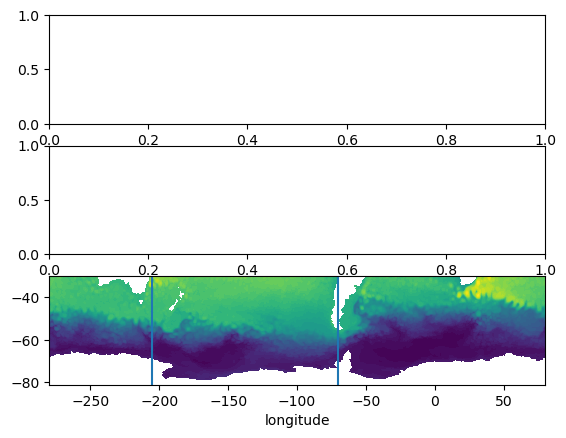

In [67]:
fig, axs = plt.subplots(3, 1)#, subplot_kw={'projection': ccrs.PlateCarree()})

axs[0].contourf(access_data.xt_ocean, access_data.yt_ocean, access_data.surface_salt[0,:,:], 60)#, transform=ccrs.PlateCarree())
axs[1].contourf(access_data.xt_ocean, access_data.yt_ocean, access_data.surface_pot_temp[0,:,:])#, 60, transform=ccrs.PlateCarree())
axs[2].contourf(access_data.xt_ocean, access_data.yt_ocean, access_data.sea_level[0,:,:], 60)#, transform=ccrs.PlateCarree())
axs[2].set_xlabel('longitude')
# axs[2].gridlines()
axs[2].axvline(-205)
axs[2].axvline(-70)
plt.show()

# Selecting only the data located at 60S

In [6]:
access_data_60S_so = access_data.sel(yt_ocean = -60, yu_ocean = -60, method='nearest')

access_data_60S_so

<xarray.Dataset>
Dimensions:           (xt_ocean: 3600, time: 349, st_ocean: 75, xu_ocean: 3600)
Coordinates:
  * xt_ocean          (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
    yt_ocean          float64 -60.0
  * time              (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-1...
    yu_ocean          float64 -60.02
  * st_ocean          (st_ocean) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * xu_ocean          (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
Data variables:
    sea_level         (time, xt_ocean) float32 ...
    surface_pot_temp  (time, xt_ocean) float32 ...
    surface_salt      (time, xt_ocean) float32 ...
    temp_yflux_adv    (time, st_ocean, xt_ocean) float32 ...
    u                 (time, st_ocean, xu_ocean) float32 ...
    v                 (time, st_ocean, xu_ocean) float32 ...
    pbot_t            (time, xt_ocean) float32 ...

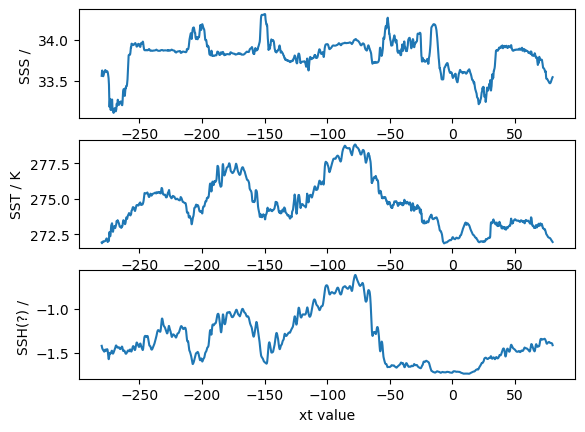

In [7]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(access_data_60S_so.xt_ocean, access_data_60S_so.surface_salt[0,:])
axs[0].set_ylabel('SSS / ')
axs[1].plot(access_data_60S_so.xt_ocean, access_data_60S_so.surface_pot_temp[0,:])
axs[1].set_ylabel('SST / K')
axs[2].plot(access_data_60S_so.xt_ocean, access_data_60S_so.sea_level[0,:])
axs[2].set_ylabel('SSH(?) / ')
axs[2].set_xlabel('xt value')
plt.show()

KeyboardInterrupt: 

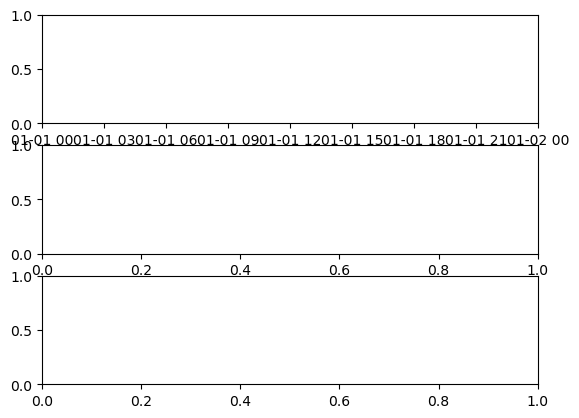

In [8]:
fig, axs = plt.subplots(3, 1)

axs[0].contourf(access_data_60S_so.time, access_data_60S_so.xt_ocean, access_data_60S_so.surface_salt.T, 60)
axs[0].set_ylabel('xt')
axs[1].contourf(access_data_60S_so.time, access_data_60S_so.xt_ocean, access_data_60S_so.surface_pot_temp.T, 60)
axs[1].set_ylabel('xt')
axs[2].contourf(access_data_60S_so.time, access_data_60S_so.xt_ocean, access_data_60S_so.sea_level.T, 60)
axs[2].set_ylabel('xt')
axs[2].set_xlabel('time')
plt.show()

To-do:
- understand variables as above
- calculate streamfunction from variables
- create numpy arrays of data that can be directly used to train/test model


In [68]:
def sigma_2_to_depth(sigma_2):
    # calculate the depth of a given potential density surface, right now we don't know how to do this so we'll input potential density as if it is depth
    return sigma_2

def calc_x_bounds(y, basin):
    # calculate the x bounds of a given basin at a given latitude - ask emilio for this
    if y == -60:
        return (-280, 80)
    elif y == -30 and basin == 'atlantic':
        return (-50, 15)
    elif y == -30 and basin == 'pacific':
        return (-205, -70)
    else:
        return

access_data_v = access_data.v

def streamfunction(data, y=-60, basin='southern'):
    # set sigma_2 as a coordinate
    data = data.assign_coords(sigma_2=data.st_ocean)


    # calculate grid cell areas
    rad_at_lat_y = 6371000 * np.cos(np.deg2rad(y)) # convert from degrees to meters
    data['dxu'] = data.xu_ocean.diff('xu_ocean') # grid cell width in longitude
    data['dxm'] = rad_at_lat_y * np.deg2rad(data.dxu) # grid cell width in meters
    data['dst'] = data.st_ocean.diff('st_ocean') # grid cell width in depth

    data = data.reset_coords(['dxm', 'dst']) # make these data variables instead of coordinates bcus it makes more sense

    data['streamfunction'] = xr.DataArray(np.zeros((len(data.sigma_2), len(data.time))), coords=[data.st_ocean, data.time])

    x_bounds = calc_x_bounds(y, basin)
    data = data.sel(yu_ocean = y, method='nearest')
    for i, sigma_2 in enumerate(data.st_ocean):
        # here we assume that sigma_2 is a depth, whereas it's supposed to be a potential density
        min_depth = sigma_2_to_depth(sigma_2)

        # sum across all longitudes, weighted by the grid cell width
        data['v_weighted_by_dxm'] = data.v * data.dxm
        data['v_weighted_by_dxm_summed_over_x'] = data.v_weighted_by_dxm.sel(xu_ocean=slice(*x_bounds)).sum('xu_ocean')
        # sum across all depths up to min_depth, weighted by grid cell depth
        data['v_weighted_by_dxm_summed_over_x_weighted_by_dst'] = data.v_weighted_by_dxm_summed_over_x * data.dst
        data['v_weighted_by_dxm_summed_over_x_weighted_by_dst_summed_over_z'] = data.v_weighted_by_dxm_summed_over_x_weighted_by_dst.sel(st_ocean=slice(min_depth, data.st_ocean[-1])).sum('st_ocean')
        # calculate the streamfunction
        data['streamfunction'][i,:] = -data.v_weighted_by_dxm_summed_over_x_weighted_by_dst_summed_over_z



    # plt.plot(data.time, data.streamfunction)
    return data





In [ ]:
Psi_60S_so = streamfunction(access_data_v)

In [ ]:
Psi_30S_at = streamfunction(access_data_v, y=-30, basin='atlantic')

In [69]:
Psi_30S_pac = streamfunction(access_data_v, y=-30, basin='pacific')

In [70]:
Psi_30S_pac

<xarray.Dataset>
Dimensions:                                                        (time: 349,
                                                                    st_ocean: 75,
                                                                    xu_ocean: 3600)
Coordinates:
  * time                                                           (time) datetime64[ns] ...
    yu_ocean                                                       float64 -3...
  * st_ocean                                                       (st_ocean) float64 ...
  * xu_ocean                                                       (xu_ocean) float64 ...
    sigma_2                                                        (st_ocean) float64 ...
    dxu                                                            (xu_ocean) float64 ...
Data variables:
    dxm                                                            (xu_ocean) float64 ...
    dst                                                            (st_ocean) float64 ...
    v                                                              (time, st_ocean, xu_ocean) float32 ...
    streamfunction                                                 (st_ocean, time) float64 ...
    v_weighted_by_dxm                                              (time, st_ocean, xu_ocean) float64 ...
    v_weighted_by_dxm_summed_over_x                                (time, st_ocean) float64 ...
    v_weighted_by_dxm_summed_over_x_weighted_by_dst                (time, st_ocean) float64 ...
    v_weighted_by_dxm_summed_over_x_weighted_by_dst_summed_over_z  (time) float64 ...

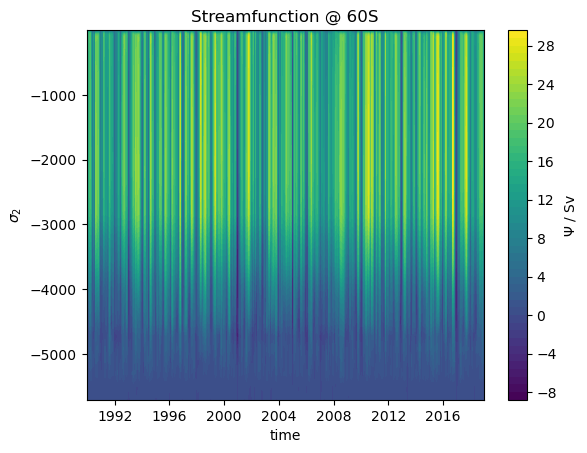

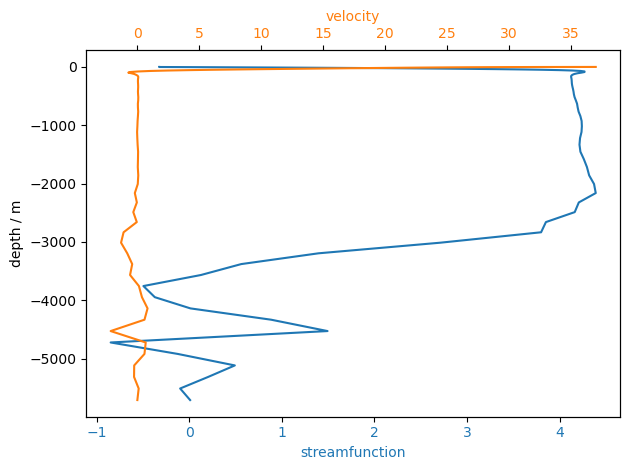

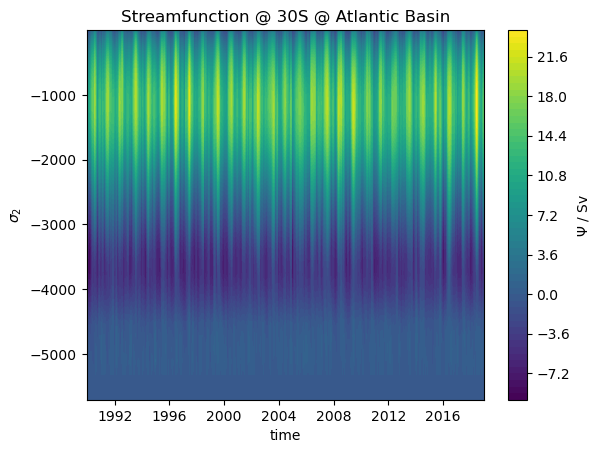

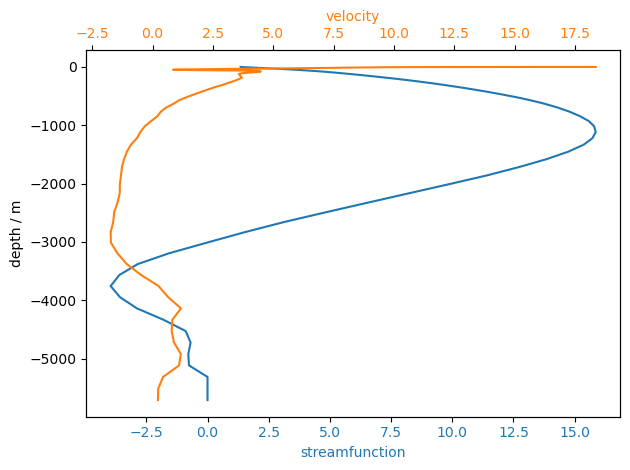

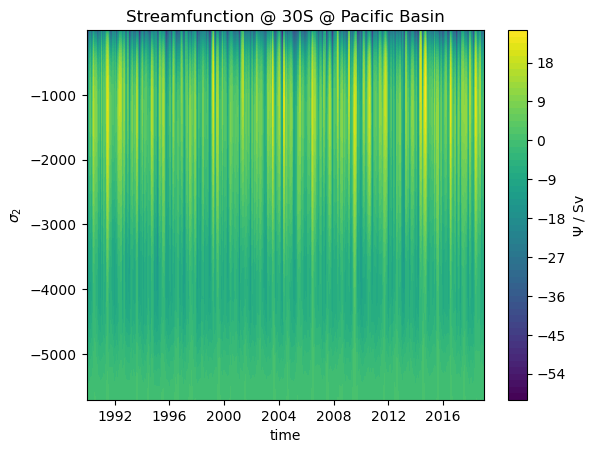

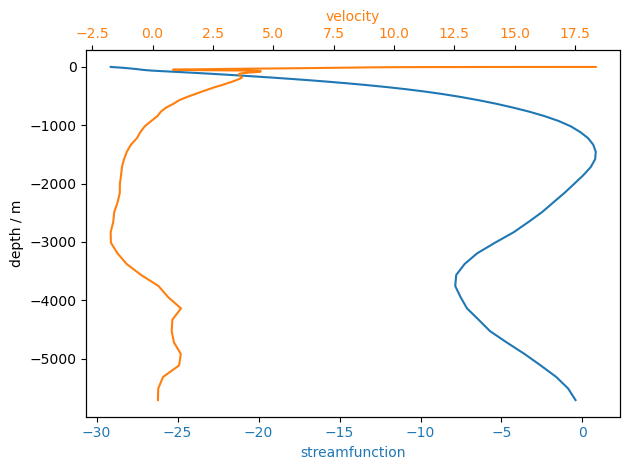

In [71]:
'''
60S Southern Basin (obvs)
'''
plt.contourf(Psi_60S_so.time, -Psi_60S_so.st_ocean[::], Psi_60S_so.streamfunction*1e-6, 60)
plt.colorbar(label=r'$\Psi$ / Sv')
plt.xlabel('time')
plt.ylabel(r'$\sigma_2$')
plt.title('Streamfunction @ 60S')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('depth / m')
ax1.set_xlabel('streamfunction', color=color)
ax1.plot(Psi_60S_so.streamfunction[:,5]*1e-6, -Psi_60S_so.st_ocean[::], color=color)
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_xlabel('velocity', color=color)  # we already handled the x-label with ax1
ax2.plot(Psi_60S_so.v.sum(dim=['xu_ocean'])[5,:], -Psi_60S_so.st_ocean[::], color=color)
ax2.tick_params(axis='x', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

'''
30S Atlantic Basin
'''
plt.contourf(Psi_30S_at.time, -Psi_30S_at.st_ocean[::], Psi_30S_at.streamfunction*1e-6, 60)
plt.colorbar(label=r'$\Psi$ / Sv')
plt.xlabel('time')
plt.ylabel(r'$\sigma_2$')
plt.title('Streamfunction @ 30S @ Atlantic Basin')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('depth / m')
ax1.set_xlabel('streamfunction', color=color)
ax1.plot(Psi_30S_at.streamfunction[:,5]*1e-6, -Psi_30S_at.st_ocean[::], color=color)
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_xlabel('velocity', color=color)  # we already handled the x-label with ax1
ax2.plot(Psi_30S_at.v.sum(dim=['xu_ocean'])[5,:], -Psi_30S_at.st_ocean[::], color=color)
ax2.tick_params(axis='x', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

'''
30S Pacific Basin
'''
plt.contourf(Psi_30S_pac.time, -Psi_30S_pac.st_ocean[::], Psi_30S_pac.streamfunction*1e-6, 60)
plt.colorbar(label=r'$\Psi$ / Sv')
plt.xlabel('time')
plt.ylabel(r'$\sigma_2$')
plt.title('Streamfunction @ 30S @ Pacific Basin')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('depth / m')
ax1.set_xlabel('streamfunction', color=color)
ax1.plot(Psi_30S_pac.streamfunction[:,5]*1e-6, -Psi_30S_pac.st_ocean[::], color=color)
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_xlabel('velocity', color=color)  # we already handled the x-label with ax1
ax2.plot(Psi_30S_pac.v.sum(dim=['xu_ocean'])[5,:], -Psi_30S_pac.st_ocean[::], color=color)
ax2.tick_params(axis='x', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Find $\sigma_2^0$ - the "depth" at which the time-averaged absolute value of the streamfunction is maximised (using first Solodoch method)

<xarray.DataArray 'sigma_2' ()>
array(2006.97521973)
Coordinates:
    yu_ocean  float64 -60.02
    st_ocean  float64 2.007e+03
    sigma_2   float64 2.007e+03
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean


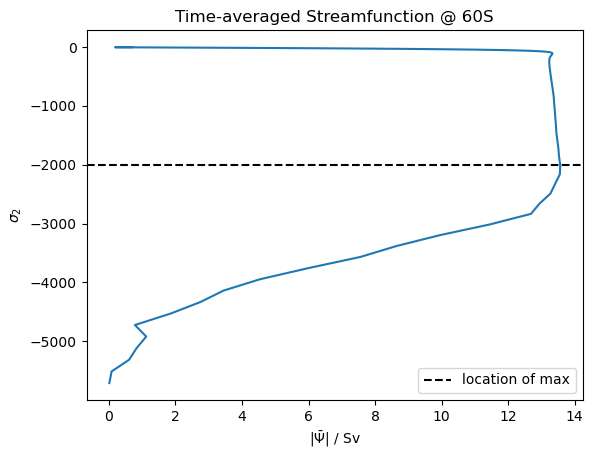

<xarray.DataArray 'sigma_2' ()>
array(1115.06799316)
Coordinates:
    yu_ocean  float64 -30.02
    st_ocean  float64 1.115e+03
    sigma_2   float64 1.115e+03
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean


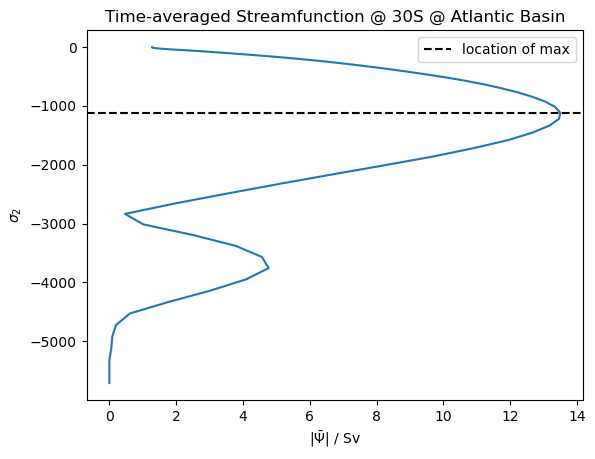

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.DataArray 'sigma_2' (st_ocean: 2)>
array([       nan, 1.68073463])
Coordinates:
    yu_ocean  float64 -30.02
  * st_ocean  (st_ocean) float64 0.5413 1.681
    sigma_2   (st_ocean) float64 nan 1.681
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean


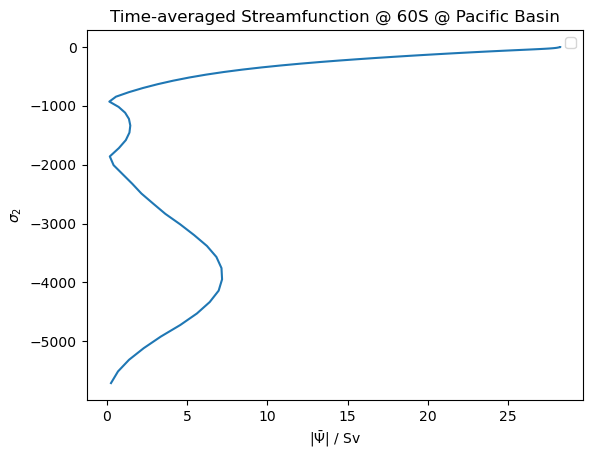

In [74]:
'''
Streamfunction @ 60S
'''
abs_t_avg_Psi_60S_so = abs(Psi_60S_so.streamfunction.mean(axis=1))
sigma_2_0_60S_so = abs_t_avg_Psi_60S_so.where(abs_t_avg_Psi_60S_so==abs_t_avg_Psi_60S_so.max(), drop=True).squeeze().sigma_2 # some code I found online to find the location of a maximum value in an xarray
print(sigma_2_0_60S_so)

plt.plot(abs_t_avg_Psi_60S_so*1e-6, -Psi_60S_so.st_ocean)
plt.axhline(-sigma_2_0_60S_so, color='black', linestyle='--', label='location of max')
plt.legend()
plt.ylabel(r'$\sigma_2$')
plt.xlabel(r'$|\bar{\Psi}|$ / Sv')
plt.title('Time-averaged Streamfunction @ 60S')
plt.show()

'''
Streamfunction @ 30S @ Atlantic
'''
abs_t_avg_Psi_30S_at = abs(Psi_30S_at.streamfunction.mean(axis=1))
sigma_2_0_30S_at = abs_t_avg_Psi_30S_at.where(abs_t_avg_Psi_30S_at==abs_t_avg_Psi_30S_at.max(), drop=True).squeeze().sigma_2 # some code I found online to find the location of a maximum value in an xarray
print(sigma_2_0_30S_at)

plt.plot(abs_t_avg_Psi_30S_at*1e-6, -Psi_30S_at.st_ocean)
plt.axhline(-sigma_2_0_30S_at, color='black', linestyle='--', label='location of max')
plt.legend()
plt.ylabel(r'$\sigma_2$')
plt.xlabel(r'$|\bar{\Psi}|$ / Sv')
plt.title('Time-averaged Streamfunction @ 30S @ Atlantic Basin')
plt.show()

'''
Streamfunction @ 30S @ Pacific
'''
abs_t_avg_Psi_30S_pac = abs(Psi_30S_pac.streamfunction.mean(axis=1))
sigma_2_0_30S_pac = abs_t_avg_Psi_30S_pac.where(abs_t_avg_Psi_30S_pac==abs_t_avg_Psi_30S_pac.max(), drop=True).squeeze().sigma_2 # some code I found online to find the location of a maximum value in an xarray
print(sigma_2_0_30S_pac)

plt.plot(abs_t_avg_Psi_30S_pac*1e-6, -Psi_30S_pac.st_ocean)
# plt.axhline(-sigma_2_0_30S_pac, color='black', linestyle='--', label='location of max')
plt.legend()
plt.ylabel(r'$\sigma_2$')
plt.xlabel(r'$|\bar{\Psi}|$ / Sv')
plt.title('Time-averaged Streamfunction @ 60S @ Pacific Basin')
plt.show()



Create final MOC strength array for use in modelling

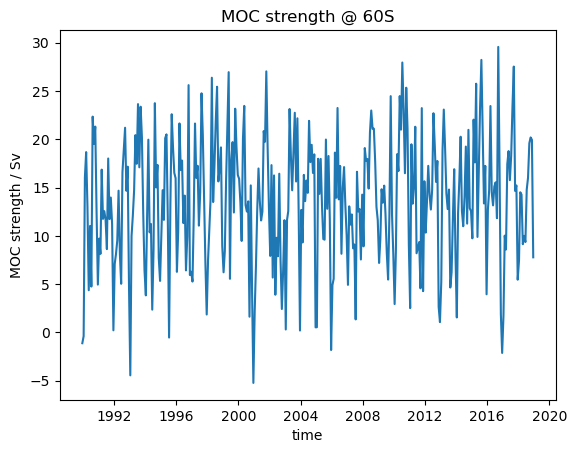

<xarray.Dataset>
Dimensions:   (time: 349)
Coordinates:
  * time      (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-16T12:00:00
    yu_ocean  float64 -60.02
    st_ocean  float64 2.007e+03
    sigma_2   float64 2.007e+03
Data variables:
    MOC       (time) float64 -1.111e+06 -3.818e+05 ... 1.993e+07 7.776e+06

In [15]:
MOC_60S_so = Psi_60S_so.streamfunction.sel(st_ocean=sigma_2_0_60S_so, method='nearest').to_dataset(name='MOC')


plt.plot(Psi_60S_so.time, MOC_60S_so.MOC*1e-6)
plt.xlabel('time')
plt.ylabel(r'MOC strength / Sv')
plt.title('MOC strength @ 60S')
plt.show()

MOC_60S_so

[-3.28298333e+06  1.11271274e+00  5.56923097e+03  1.26031861e+07]


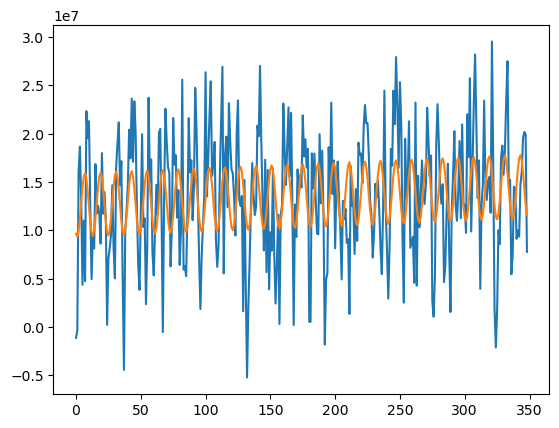

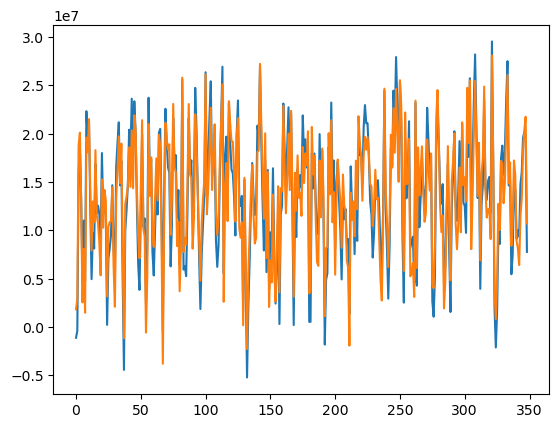

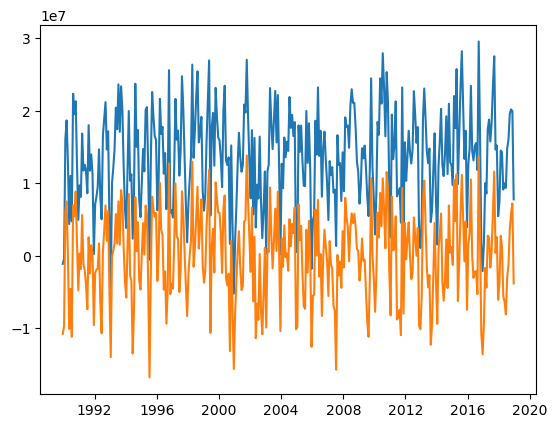

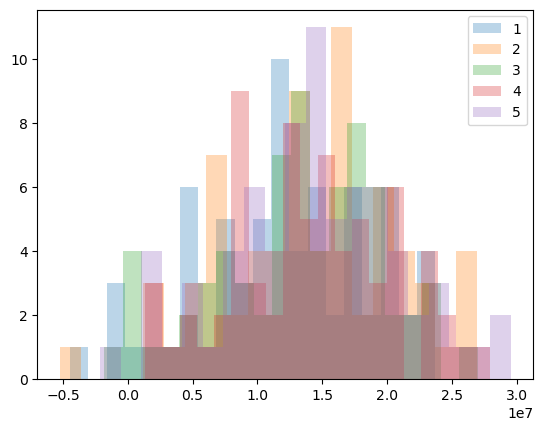

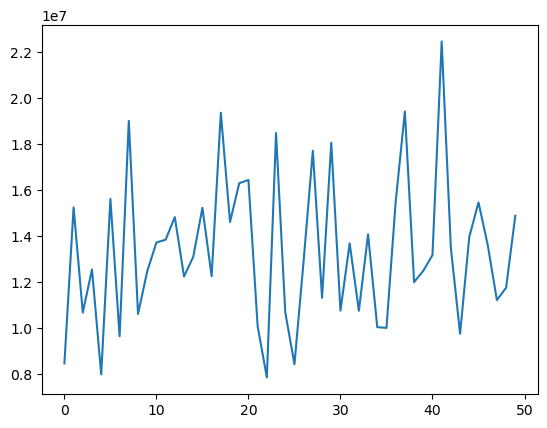

In [38]:
def sin_lin(x, a, c, d, e):
    return a * np.sin(2 * np.pi * (1/12) * x + c) + d * x + e
def sin(x, a, b):
    return a * np.sin(2 * np.pi * (1/12) * x + b)

MOC_timestamps = pd.to_datetime(MOC_60S_so.time.values)
initial_timestamp = MOC_timestamps.min()
months_elapsed = (MOC_timestamps.year - initial_timestamp.year) * 12 + (MOC_timestamps.month - initial_timestamp.month)
months_elapsed_np = months_elapsed.to_numpy()

fit, cov = op.curve_fit(sin_lin, months_elapsed_np, MOC_60S_so.MOC_60S_so, p0=[1e7, 0.1, 100, 1e7])
print(fit)

MOC_60S_so['MOC_deseasoned'] = MOC_60S_so.MOC_60S_so - sin(months_elapsed_np, *fit[:2])
MOC_60S_so['MOC_deseasoned_detrended'] = MOC_60S_so.MOC_60S_so - sin_lin(months_elapsed_np, *fit)

plt.figure()
plt.plot(months_elapsed_np, MOC_60S_so.MOC_60S_so)
plt.plot(months_elapsed_np, sin_lin(months_elapsed_np, *fit))
plt.show()

plt.figure()
plt.plot(months_elapsed_np, MOC_60S_so.MOC_60S_so)
plt.plot(months_elapsed_np, MOC_60S_so.MOC_deseasoned) # seasonal component seems to be very small, so investigate this
plt.show()

plt.figure()
plt.plot(MOC_60S_so.time, MOC_60S_so.MOC_60S_so)
plt.plot(MOC_60S_so.time, MOC_60S_so.MOC_deseasoned_detrended)
plt.show()

MOC_60S_so.MOC.to_netcdf('processed_data/MOC_60S_so.nc', format="NETCDF4")

plt.hist(MOC_60S_so.MOC_60S_so[:int(len(MOC_60S_so.MOC_60S_so)/5)], bins=20, alpha=0.3, label='1')
plt.hist(MOC_60S_so.MOC_60S_so[int(len(MOC_60S_so.MOC_60S_so)/5):2*int(len(MOC_60S_so.MOC_60S_so)/5)], bins=20, alpha=0.3, label='2')
plt.hist(MOC_60S_so.MOC_60S_so[2*int(len(MOC_60S_so.MOC_60S_so)/5):3*int(len(MOC_60S_so.MOC_60S_so)/5)], bins=20, alpha=0.3, label='3')
plt.hist(MOC_60S_so.MOC_60S_so[3*int(len(MOC_60S_so.MOC_60S_so)/5):4*int(len(MOC_60S_so.MOC_60S_so)/5)], bins=20, alpha=0.3, label='4')
plt.hist(MOC_60S_so.MOC_60S_so[4*int(len(MOC_60S_so.MOC_60S_so)/5):], bins=20, alpha=0.3, label='5')
plt.legend()
plt.show()


n = 50
plt.plot(np.mean([MOC_60S_so.MOC_60S_so[i*int(len(MOC_60S_so.MOC_60S_so)/n):(i+1)*int(len(MOC_60S_so.MOC_60S_so)/n)] for i in range(n)], axis=1))

Create final input array for modelling

In [76]:
# select only surface data
input_data_60S_so = access_data_60S_so.sel(st_ocean=0, method='nearest')

input_data_60S_so.to_netcdf('processed_data/input_data_60S_so.nc', format="NETCDF4")

# select only surface data
access_data_30S = access_data.sel(yt_ocean = -30, yu_ocean = -30, method='nearest')
access_data_30S_at = access_data_30S.sel(xt_ocean = slice(-50, 15), xu_ocean = slice(-50, 15))
input_data = access_data_30S_at.sel(st_ocean=0, method='nearest')

input_data.to_netcdf('processed_data/input_data_30S_at.nc', format="NETCDF4")

# select only surface data
access_data_30S = access_data.sel(yt_ocean = -30, yu_ocean = -30, method='nearest')
access_data_30S_pac = access_data_30S.sel(xt_ocean = slice(-205, -70), xu_ocean = slice(-205, -70))
input_data = access_data_30S_pac.sel(st_ocean=0, method='nearest')

input_data.to_netcdf('processed_data/input_data_30S_pac.nc', format="NETCDF4")

implement looking at the gradient of the MOC strength

look at the statistics of the MOC strength changing over time (fat-tailed distributions etc) - low-hanging


use sss at the continental shelf as a covariate for all latitudes

look at using 5-day average data - email aditya

Seesaw effect between different circulation strengths - can data from one circulation be used to predict the other?
